El objetivo es **identificar para cada municipio**, que tenga KPI, **las entidades emisoras que tiene a un radio de 10,20 y 30 KM**.
Se calcularán las emisiones totales por municipio generadas por la plantas situadas a esa distancia.

In [32]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

## Carga de datos y preparación del entorno espacial

Descripción: Esta celda de código realiza las siguientes acciones:

* **Carga de datos**: Se cargan tres conjuntos de datos en formato CSV y Shapefile utilizando las funciones gpd.read_file() y pd.read_csv(). Los archivos se encuentran en las rutas especificadas.

* **Preparación del entorno espacial**: Se realizan varias operaciones para preparar los datos para su análisis espacial.

    1. Configuración del índice: El DataFrame gpd_municipio se configura para tener como índice la columna "codine" utilizando el método set_index().

    2. Filtrado de datos: Se filtra el DataFrame gpd_municipio para mantener solo las filas cuyos índices coinciden con los del DataFrame kpi utilizando la función loc[].

    3. Conversión a GeoDataFrame: Se crea una nueva columna "geometry" en el DataFrame aggEmisiones utilizando las columnas "longitud" y "latitud" para representar las coordenadas de cada punto. Luego, se convierte el DataFrame en un GeoDataFrame utilizando la clase gpd.GeoDataFrame().

    4. Establecimiento del sistema de coordenadas: El GeoDataFrame aggEmisiones se configura con el mismo sistema de coordenadas que el GeoDataFrame gpd_municipio utilizando el método

In [33]:

# Cargar los datos
gpd_municipio = gpd.read_file('../factores/output/gpd_municipio.shp')
gpd_municipio.set_index('codine', inplace=True)

aggEmisiones = pd.read_csv('../factores/output/aggEmisiones.csv')
num_fact = ['CH4','CO','CO2','COT','COVNM','N2O','NH3','NO2','OTH','PM10','PST','SO2']

kpi = pd.read_csv('../kpis/output/edv_qx.csv',index_col="codine")

gpd_municipio = gpd_municipio.loc[kpi.index]

print("Data imported")

# Convertir aggEmisiones a un GeoDataFrame
geometry = [Point(xy) for xy in zip(aggEmisiones.longitud, aggEmisiones.latitud)]
aggEmisiones = gpd.GeoDataFrame(aggEmisiones, geometry=geometry)
print("Data converted to GeoDataFrame")

# Establecer el mismo sistema de coordenadas
aggEmisiones.set_crs(gpd_municipio.crs, inplace=True)
print("Data crs set")


Data imported
Data converted to GeoDataFrame
Data crs set


## Creación de buffers y cálculo de sumas por municipio

Se realizan las siguientes tareas:

1. **Crea buffers alrededor de cada municipio** con diferentes radios (10 km, 20 km y 30 km).
2. Se realiza **un bucle para cada buffer** creado. Dentro de este bucle:
    1. Para cada municipio se seleccionan las emisiones que caen dentro del área del municipio, más el buffer, utilizando la función within() del objeto aggEmisiones.
    2. Se calcula la suma de las emisiones para cada factor numérico especificado y se almacena en columnas adicionales en el DataFrame gpd_municipio.

In [34]:

# Crear un buffer de 30 km alrededor de cada municipio
gpd_municipio.reset_index(inplace=True, drop=False)

gpd_municipio_buf10 = gpd_municipio.to_crs('EPSG:32630')
gpd_municipio_buf10['geometry'] = gpd_municipio_buf10.geometry.buffer(10 * 1000)  # 10 km en metros
gpd_municipio_buf10.to_crs('EPSG:4258', inplace=True)

gpd_municipio_buf20 = gpd_municipio.to_crs('EPSG:32630')
gpd_municipio_buf20['geometry'] = gpd_municipio_buf20.geometry.buffer(20 * 1000)  # 20 km en metros
gpd_municipio_buf20.to_crs('EPSG:4258', inplace=True)

gpd_municipio_buf30 = gpd_municipio.to_crs('EPSG:32630')
gpd_municipio_buf30['geometry'] = gpd_municipio_buf30.geometry.buffer(30 * 1000)  # 30 km en metros
gpd_municipio_buf30.to_crs('EPSG:4258', inplace=True)
print("Buffers created")

# Para cada municipio, seleccionar las emisiones que caen dentro del buffer y sumarlas
for buf in [(10, gpd_municipio_buf10), (20, gpd_municipio_buf20), (30, gpd_municipio_buf30)]:
    print(f"Ejecuantdo buffer de {buf[0]} km")
    for i, municipio in buf[1].iterrows():
        emisiones_in_municipio = aggEmisiones[aggEmisiones.within(municipio.geometry)]
        for f in num_fact:
            for g in ["sum","max","mean"]:
                gpd_municipio.loc[i, f"{f}_{g}_b{buf[0]}"] = emisiones_in_municipio[f"{f}_{g}"].sum()

        if i % 30 == 0:
            print(f"{i}/{len(buf[1])} municipios procesados")

Buffers created
Ejecuantdo buffer de 10 km
0/153 municipios procesados
30/153 municipios procesados
60/153 municipios procesados
90/153 municipios procesados
120/153 municipios procesados
150/153 municipios procesados
Ejecuantdo buffer de 20 km
0/153 municipios procesados
30/153 municipios procesados
60/153 municipios procesados
90/153 municipios procesados
120/153 municipios procesados
150/153 municipios procesados
Ejecuantdo buffer de 30 km
0/153 municipios procesados


/home/ander/Documentos/06_Proyecto_programacion/Python/Analisis_longevidad/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/ander/Documentos/06_Proyecto_programacion/Python/Analisis_longevidad/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/ander/Documentos/06_Proyecto_programacion/Python/Analisis_longevidad/.venv/lib/python3.1

30/153 municipios procesados
60/153 municipios procesados
90/153 municipios procesados
120/153 municipios procesados
150/153 municipios procesados


## Dibujamos los buffers para comprobar que tiene sentido.
Se plotean:
* Los boundaries para cada bufer.
* El centroide de cada municipio
* Los complejos contaminantes

/tmp/ipykernel_44530/3049746803.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd_municipio.geometry.centroid.plot(ax=ax, color='red', markersize=5)


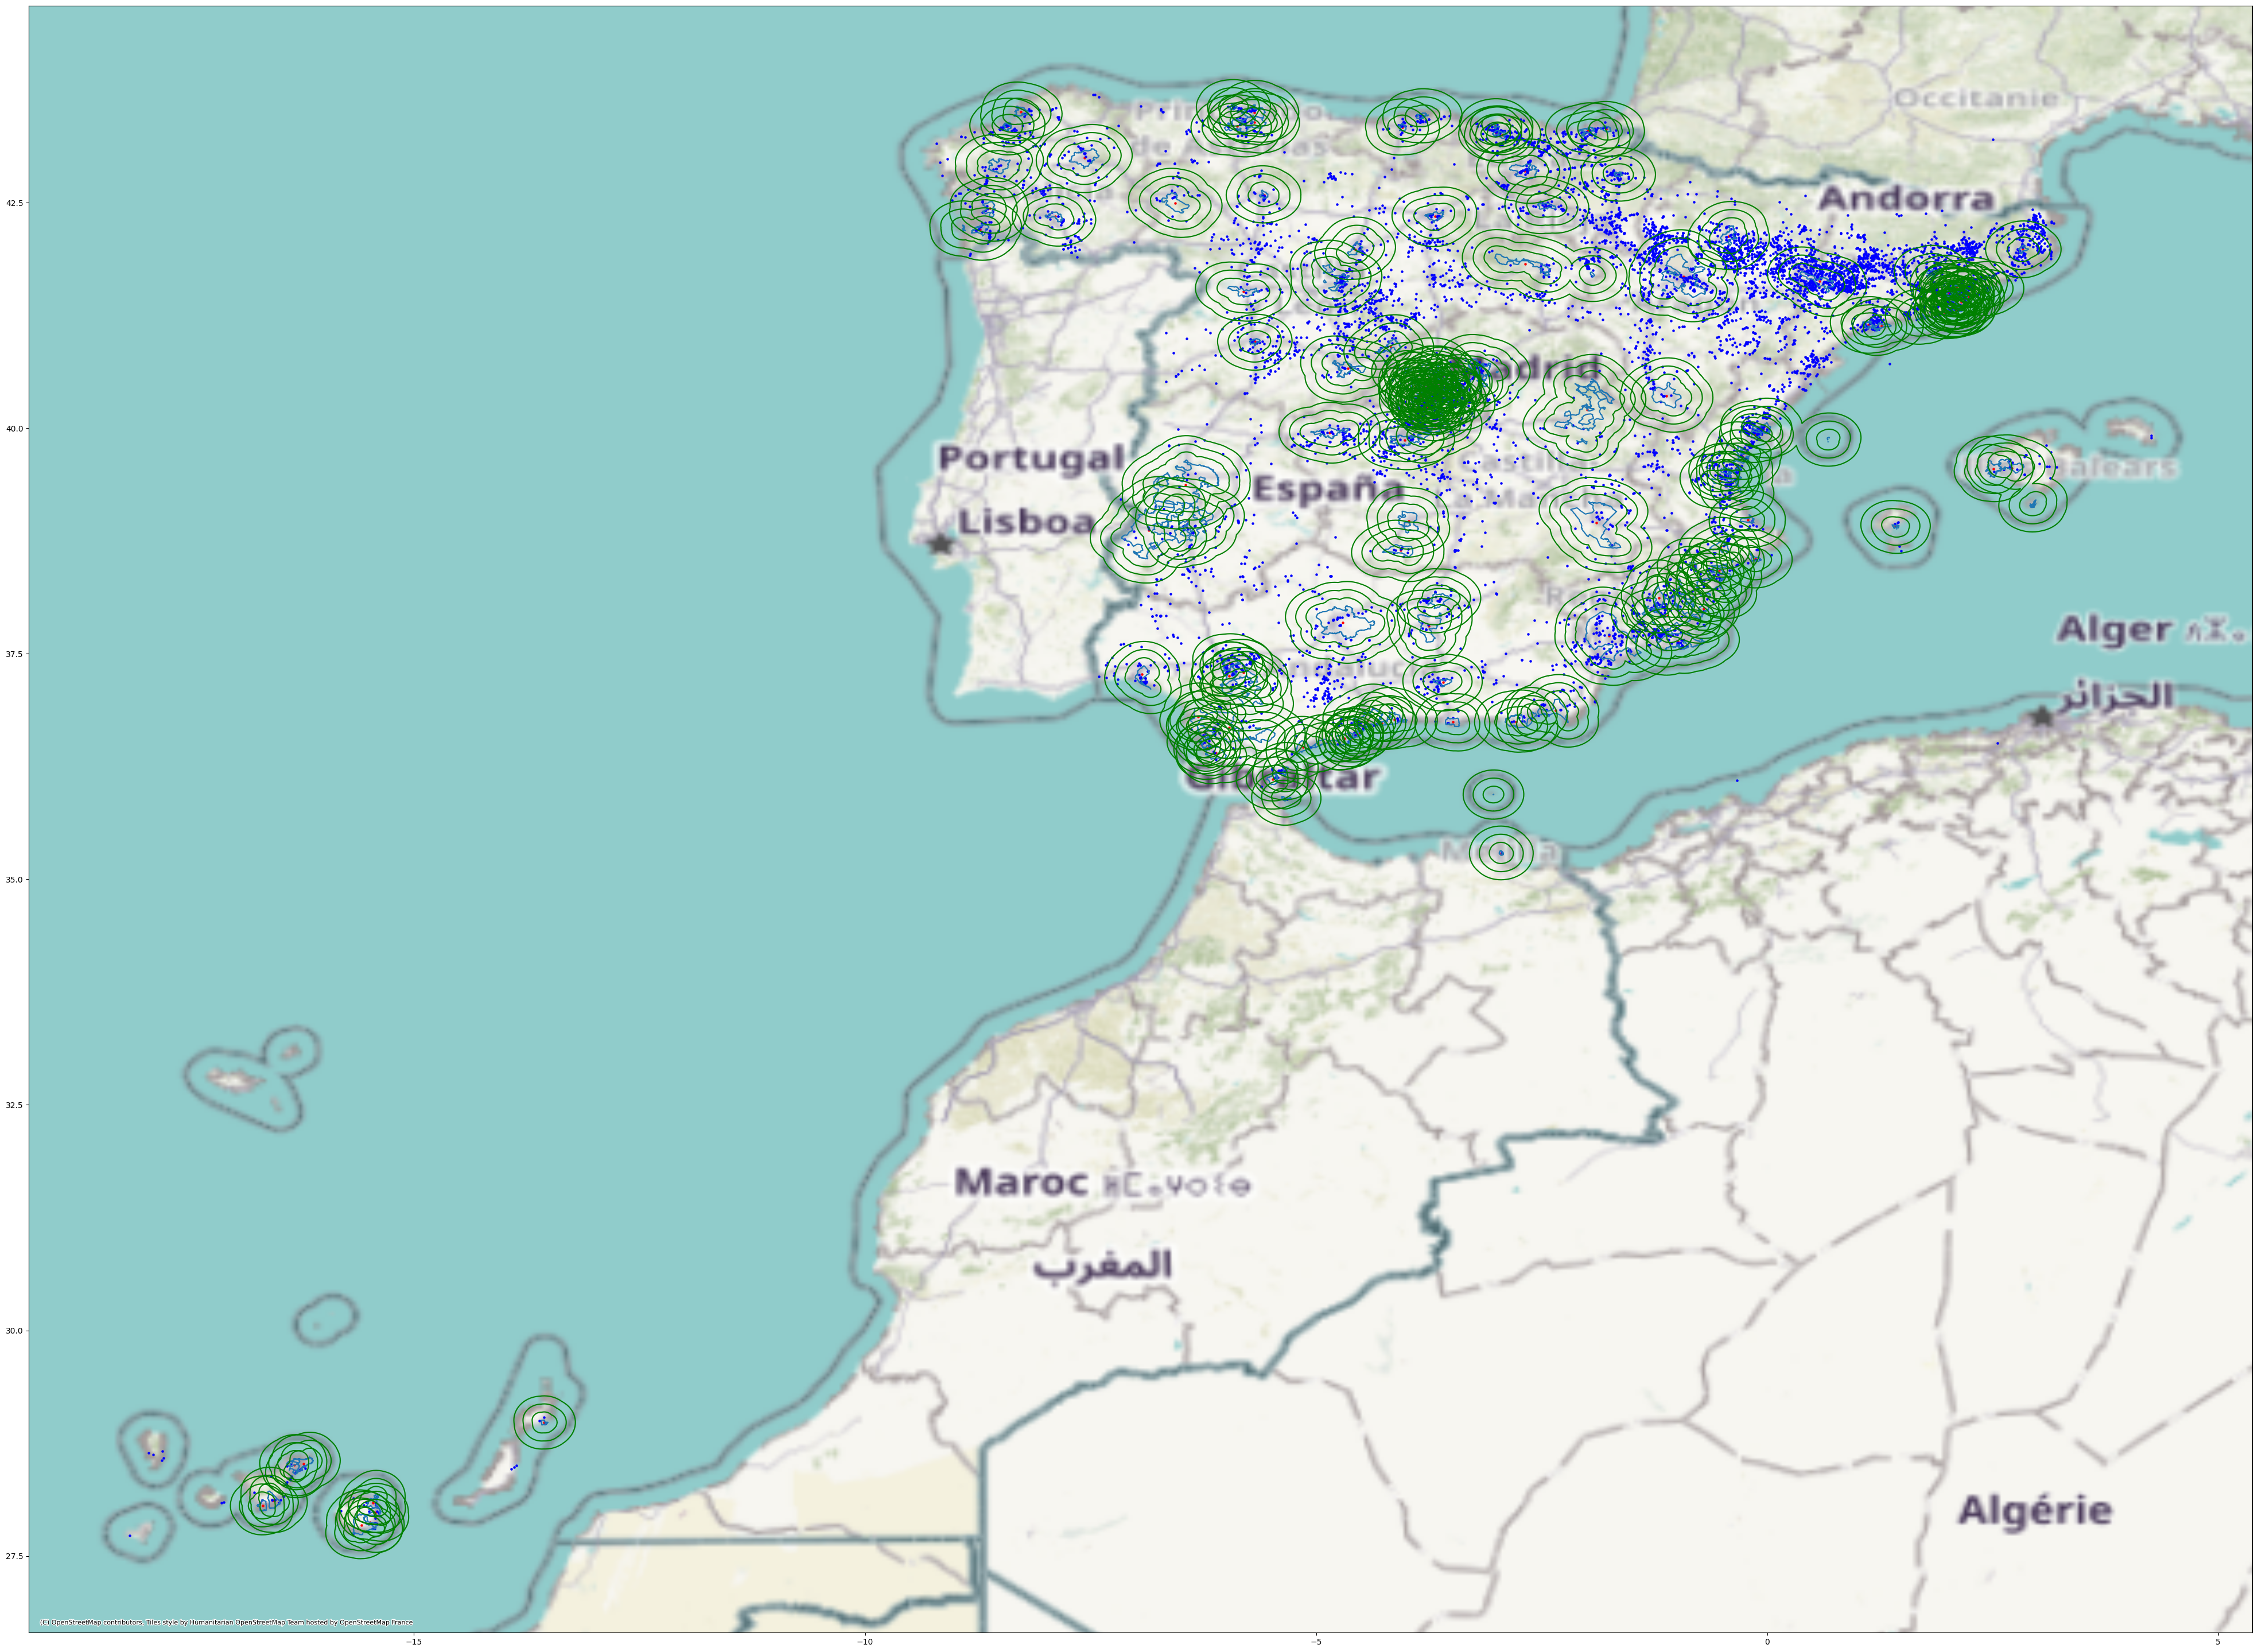

In [35]:
fig, ax = plt.subplots(figsize=(50, 50))
gpd_municipio.to_crs(epsg=4326, inplace=True)
gpd_municipio_buf10.to_crs(epsg=4326, inplace=True)
gpd_municipio_buf20.to_crs(epsg=4326, inplace=True)
gpd_municipio_buf30.to_crs(epsg=4326, inplace=True)

gpd_municipio.boundary.plot(ax=ax)
gpd_municipio_buf10.boundary.plot(ax=ax, color='green')
gpd_municipio_buf20.boundary.plot(ax=ax, color='green')
gpd_municipio_buf30.boundary.plot(ax=ax, color='green')
gpd_municipio.geometry.centroid.plot(ax=ax, color='red', markersize=5)
#gpd_municipio.geometry_buf.plot(ax=ax, color='red', markersize=5)
aggEmisiones.geometry.plot(ax=ax, color='blue', markersize=5)
cx.add_basemap(ax, crs=gpd_municipio.crs.to_string())

## Union Fact and KPIs:
Unimos los datos de emisiones con los KPIs a analizar.

In [36]:
gpd_municipio = gpd_municipio.set_index("codine").join(kpi)

In [37]:
eurostat = pd.read_csv("../factores/output/data_eurostat.csv").pivot_table(index="CODINE", columns="indic_ur", values="value")
#,gpd_municipio = gpd_municipio.join(eurostat.set_index("CODINE"))

In [40]:
gpd_municipio = gpd_municipio.join(eurostat)

## Export:
Exportamos los datos para ser analizados en otro notebook:

In [41]:
gpd_municipio.to_csv('emisiones_x_municipio.csv',index=True,header=True,sep=",", decimal=".")

In [42]:
gpd_municipio.head(2)

INSPIREID COUNTRY  \
codine                                     
1059    ES.IGN.BDDAE.34160101059      ES   
2003    ES.IGN.BDDAE.34080202003      ES   

                                                   NATLEV NATLEVNAME  \
codine                                                                 
1059    https://inspire.ec.europa.eu/codelist/Administ...  Municipio   
2003    https://inspire.ec.europa.eu/codelist/Administ...  Municipio   

            NATCODE         NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
codine                                                         
1059    34160101059  Vitoria-Gasteiz     ES2    ES21   ES211   
2003    34080202003         Albacete     ES4    ES42   ES421   

                                                 geometry  ...  TT1020V  \
codine                                                     ...            
1059    POLYGON ((-2.84755 42.86294, -2.84769 42.86633...  ...    16.54   
2003    POLYGON ((-2.18035 39.10000, -2.16738 39.10308...  ...      NaN   

         TT1057I        TT1057V  TT1060I   TT1060V  TT1064V  TT1065V  TT1079V  \
codine                                                                          
1059    429.9875  105535.187500     0.13  7.800000  16711.0  14763.5   104.39   
2003    432.9250   74727.916667     0.19  4.833333      NaN      NaN      NaN   

        TT1080V  TT1081V  
codine                    
1059        1.0      NaN  
2003        NaN      NaN  

[2 rows x 774 columns]

In [43]:
eurostat.columns

Index(['CR1003I', 'CR1003V', 'CR1005V', 'CR1007V', 'CR1008V', 'CR1010V',
       'CR1015V', 'CR2001V', 'CR2009V', 'CR2010I',
       ...
       'TT1020V', 'TT1057I', 'TT1057V', 'TT1060I', 'TT1060V', 'TT1064V',
       'TT1065V', 'TT1079V', 'TT1080V', 'TT1081V'],
      dtype='object', name='indic_ur', length=191)